

# Data Description
This dataset contains an anonymized set of features, feature_{0...129}, representing real stock market data. Each row in the dataset represents a trading opportunity, for which you will be predicting an action value: 1 to make the trade and 0 to pass on it. Each trade has an associated weight and resp, which together represents a return on the trade. The date column is an integer which represents the day of the trade, while ts_id represents a time ordering. In addition to anonymized feature values, you are provided with metadata about the features in features.csv.

## In the training set, train.csv, you are provided a resp value, as well as several other resp_{1,2,3,4} values that represent returns over different time horizons. These variables are not included in the test set. 

## Trades with weight = 0 were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.

This is a code competition that relies on a time-series API to ensure models do not peek forward in time. To use the API, follow the instructions on the Evaluation page. When you submit your notebook, it will be rerun on an unseen test:

    During the model training phase of the competition, this unseen test set is comprised of approximately 1 million rows of historical data.
    During the live forecasting phase, the test set will use periodically updated live market data.

Note that during the second (forecasting) phase of the competition, the notebook time limits will scale with the number of trades presented in the test set. Refer to the Code Requirements for details.

This competition is evaluated on a utility score. Each row in the test set represents a trading opportunity for which you will be predicting an action value, 1 to make the trade and 0 to pass on it. Each trade j has an associated weight and resp, which represents a return.

For each date i, we define:
## Return for each day?
pi=∑j(weightij∗respij∗actionij),  

t=∑pi∑p2i−−−−√∗250|i|−−−−√,

where |i| is the number of unique dates in the test set. The utility is then defined as:
u=min(max(t,0),6)∑pi.

## Submission File

You must submit to this competition using the provided python time-series API, which ensures that models do not peek forward in time. To use the API, follow the following template in Kaggle Notebooks:

import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

for (test_df, sample_prediction_df) in iter_test:
    sample_prediction_df.action = 0 #make your 0/1 prediction here
    env.predict(sample_prediction_df)

## Files

    train.csv - the training set, contains historical data and returns
    example_test.csv - a mock test set which represents the structure of the unseen test set. You will not be directly using the test set or sample submission in this competition, as the time-series API will get/set the test set and predictions.
    example_sample_submission.csv - a mock sample submission file in the correct format
    features.csv - metadata pertaining to the anonymized features







# From what I learned, I believe it's very important to understand the data. Some thoughts:

1. The return is associated with the combination of weight and resp. If there's positive return, we can make the trade with action=1, otherwise pass the trade with action=0.

2. Each row represents a trading opportunity at certain time during that day. The weight and resp should be calculated from 130 features. The features could represent certain stock features like volume, price, MCAD, RSI, moving averages, etc.

3. There're rows with weight=0. Does it mean the return would be 0 and no action will be taken? What's the cause of weight=0, human error or some other reason?

4. It was told that trade with weight=0 will count toward scoring evaluation. Can we simply drop those rows? What effect will be for the latest model? Maybe we can first drop them.

5. There are columns with missing values. How to deal with them may affect the model greatly. What percent of the data has no missing value in all columns?

6. Are resp/weight calculated using only some features or all features?

7. The ultimate goal in my opinion is to use the code and act as market maker by doing trades during the day, gaining positive return and pushing the stock price to the goal.

## How about drop rows with missing values and weight=0 for initial modeling?

# Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import gc
%matplotlib inline

# Import data

In [2]:
train = pd.read_csv('../jane-street-market-prediction/train.csv') 

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB


## Try to save memory

Parts of the code were taken from https://www.kaggle.com/muhammadmelsherbini/jane-street-extensive-eda-pca-starter by Muhammad M. El.Sherbini

In [4]:
train.feature_0 = train.feature_0.astype(np.int8)
train.date= train.date.astype(np.int16)
train.ts_id = train.ts_id.astype(np.int32)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int16(1), int32(1), int8(1)
memory usage: 2.4 GB


### The following code loop through the dataframe to change float64 columns to float32 only if there is a really few amount of data (a very conservative threshold of 0.1%) between -.0001:.0001 to avoid hurting accuracy of small values columns

In [6]:
for i in train:
    if train[i].dtype == np.float64:
        if (((train[i] < .0001) & (train[i] > -.0001)).mean()) > .001:
            print(i)
            
for i in train:
    if train[i].dtype == np.float64:
        if (((train[i] < .0001) & (train[i] > -.0001)).mean()) < .001:
            train[i] = train[i].astype(np.float32)
            gc.collect();

weight
resp_1
resp_2
resp_3
resp_4
resp


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(129), float64(6), int16(1), int32(1), int8(1)
memory usage: 1.3 GB


## Explore the data. Find and print the  data column names that have any missing value. Use isnull and sum method.

In [8]:
# List the columns with missing values and the number of missing values

[(i, train[i].isnull().sum()) for i in train if train[i].isnull().sum() > 0 ]
        

[('feature_3', 448),
 ('feature_4', 448),
 ('feature_7', 393135),
 ('feature_8', 393135),
 ('feature_9', 788),
 ('feature_10', 788),
 ('feature_11', 80015),
 ('feature_12', 80015),
 ('feature_13', 15353),
 ('feature_14', 15353),
 ('feature_15', 6683),
 ('feature_16', 6683),
 ('feature_17', 395535),
 ('feature_18', 395535),
 ('feature_19', 788),
 ('feature_20', 788),
 ('feature_21', 81444),
 ('feature_22', 81444),
 ('feature_23', 15353),
 ('feature_24', 15353),
 ('feature_25', 6683),
 ('feature_26', 6683),
 ('feature_27', 395535),
 ('feature_28', 395535),
 ('feature_29', 788),
 ('feature_30', 788),
 ('feature_31', 81444),
 ('feature_32', 81444),
 ('feature_33', 15353),
 ('feature_34', 15353),
 ('feature_35', 6683),
 ('feature_36', 6683),
 ('feature_44', 448),
 ('feature_45', 448),
 ('feature_55', 68409),
 ('feature_56', 719),
 ('feature_58', 1),
 ('feature_59', 48),
 ('feature_72', 351426),
 ('feature_73', 788),
 ('feature_74', 64088),
 ('feature_75', 15353),
 ('feature_76', 6683),
 ('f

In [9]:
train.head(-5)

date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0           0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1           0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2           0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3           0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4           0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   
...       ...        ...       ...       ...       ...       ...       ...   
2390481   499   2.967272  0.000298  0.000298 -0.005393 -0.012472 -0.006681   
2390482   499   0.000000  0.000083  0.000083 -0.000720 -0.000198  0.000428   
2390483   499   0.000000 -0.000072 -0.000072 -0.002696 -0.008861 -0.005862   
2390484   499   0.000000  0.000448  0.000448  0.007820  0.022398  0.016301   
2390485   499   0.000000  0.000337  0.000337  0.003490  0.011295  0.008368   

         feature_0  feature_1  feature_2  ...  feature_121  feature_122  \
0                1  -1.872746  -2.191242  ...          NaN     1.168391   
1               -1  -1.349537  -1.704709  ...          NaN    -1.178850   
2               -1   0.812780  -0.256156  ...          NaN     6.115747   
3               -1   1.174379   0.344640  ...          NaN     2.838853   
4                1  -3.172026  -3.093182  ...          NaN     0.344850   
...            ...        ...        ...  ...          ...          ...   
2390481         -1  -0.779554  -0.597258  ...    -3.453253     1.173186   
2390482          1  -2.336807  -2.038102  ...    -0.815723    -0.845426   
2390483          1  -0.440426   0.963217  ...    -1.147480    -0.788729   
2390484          1   0.320197   1.012902  ...    -1.550658    -0.730171   
2390485          1  -0.367021   0.374556  ...    -0.967930    -0.852501   

         feature_123  feature_124  feature_125  feature_126  feature_127  \
0           8.313582     1.782433    14.018213     2.653056    12.600291   
1           1.777472    -0.915459     2.831612    -1.417010     2.297459   
2           9.667908     5.542871    11.671595     7.281757    10.060014   
3           0.499251     3.033731     1.513488     4.397532     1.266037   
4           4.101145     0.614252     6.623456     0.800129     5.233243   
...              ...          ...          ...          ...          ...   
2390481    -1.215500     0.170404    -3.433334     0.496345    -2.224752   
2390482     2.704413    -1.373888     0.282608    -1.676526     1.474845   
2390483     3.601078    -1.798306    -0.869715    -2.580869     0.273089   
2390484     2.161706    -1.359076    -0.716109    -1.658000     0.669367   
2390485     2.134424    -1.399027    -0.446676    -1.939232     0.440354   

         feature_128  feature_129    ts_id  
0           2.301488    11.445807        0  
1          -1.304614     1.898684        1  
2           6.638248     9.427299        2  
3           3.856384     1.013469        3  
4           0.362636     3.926633        4  
...              ...          ...      ...  
2390481     1.207851    -1.264984  2390481  
2390482    -0.977454     2.583323  2390482  
2390483    -1.305720     2.338910  2390483  
2390484    -1.017658     1.581286  2390484  
2390485    -1.222572     1.413366  2390485  

[2390486 rows x 138 columns]

In [10]:
# Drop rows where weight = 0.Those rows will not contribute to scoring evaluation

train_wt_n0 = train[train['weight'] != 0]


In [11]:
train_wt_n0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1981287 entries, 1 to 2390489
Columns: 138 entries, date to ts_id
dtypes: float32(129), float64(6), int16(1), int32(1), int8(1)
memory usage: 1.1 GB


In [12]:
# Drop rows with NaN
for i in train_wt_n0:
    if train_wt_n0[i].isnull().sum() > 0:
        train_wt_n0 = train_wt_n0[train_wt_n0[i].notna()] 

In [13]:
train_wt_n0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1664520 entries, 479 to 2390489
Columns: 138 entries, date to ts_id
dtypes: float32(129), float64(6), int16(1), int32(1), int8(1)
memory usage: 919.1 MB


In [14]:
train_wt_n0.date.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [15]:
# Number of trade opportunities in each day in train_wt_n0

pd.value_counts(train_wt_n0['date'])


44     11697
459    10176
45      8655
85      8181
47      8161
       ...  
14      1170
270      450
36       195
2         22
294       11
Name: date, Length: 500, dtype: int64

In [16]:
# So far we get rid of data 2390486-1664520/2390486 which is about 30.3% of the data. 
(2390486-1664520)/2390486

0.3036897099585607

# Data exploration

So far about 70% original data left without missing values or 0 weight. With more than 1.6 million rows of data, it's worth a try to do modeling with some more data wrangling. 

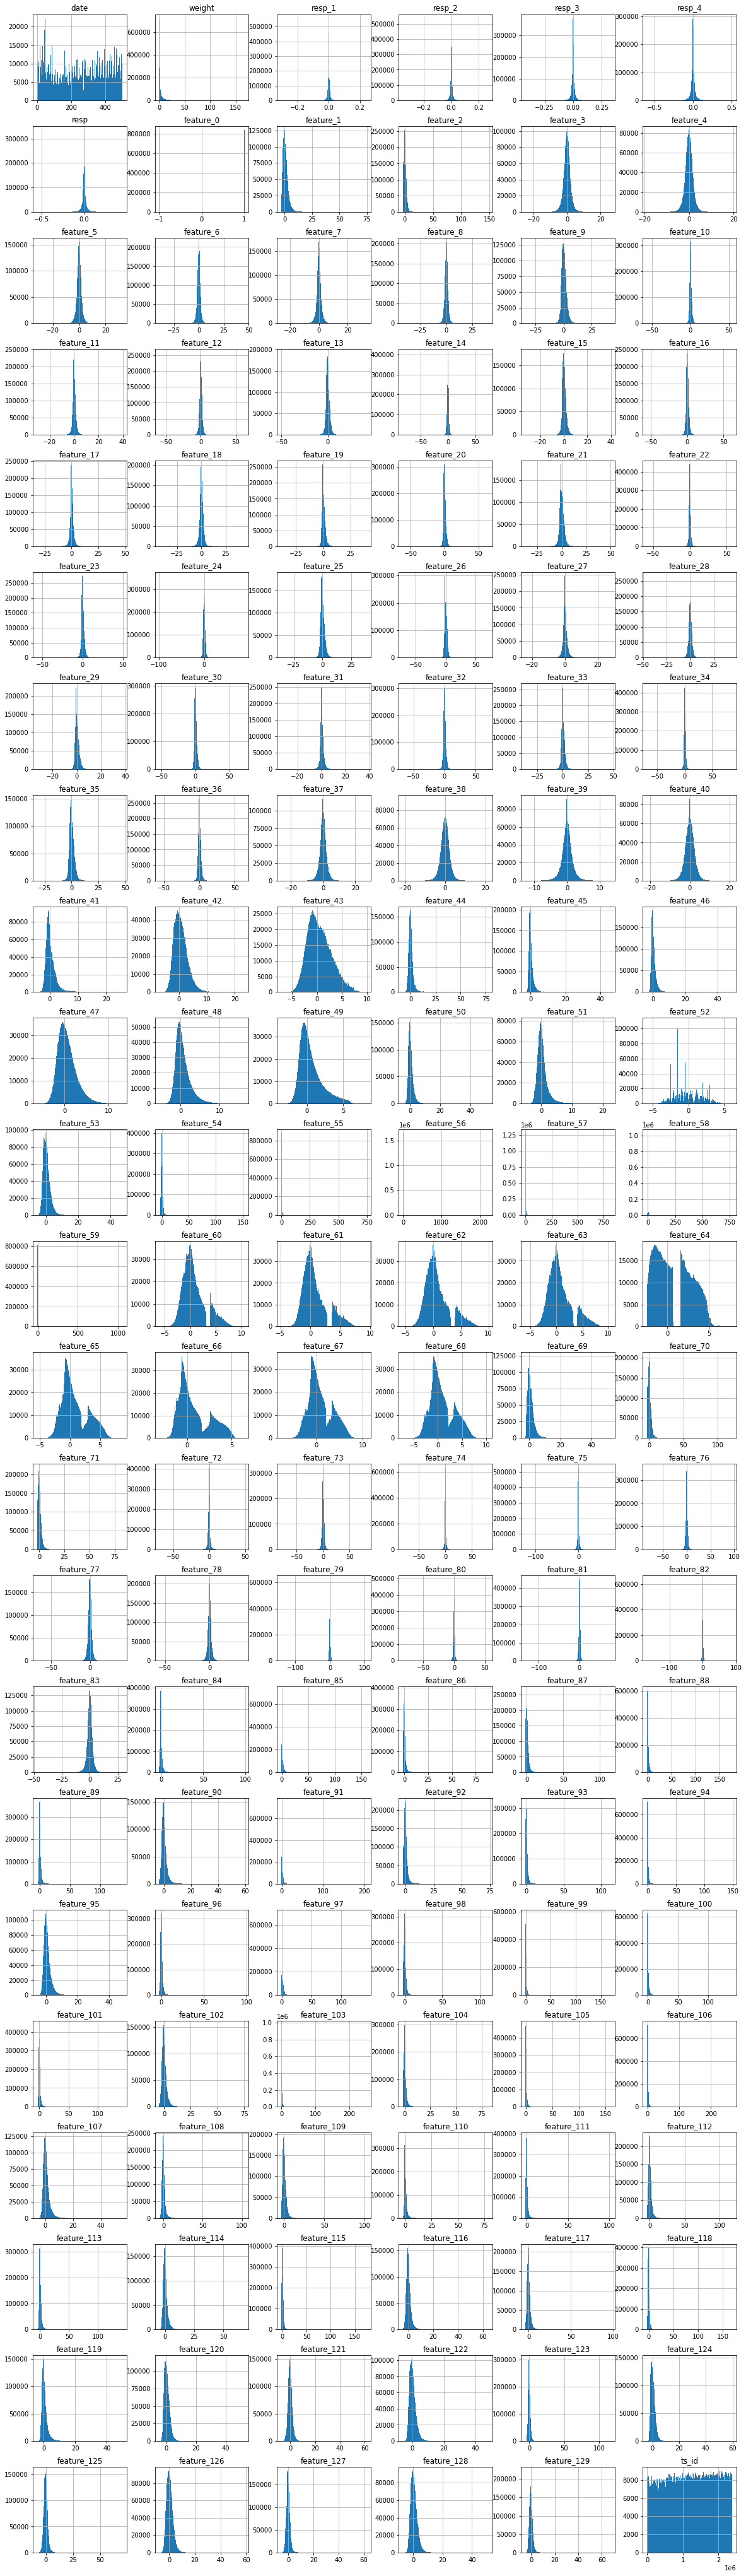

In [17]:
# 138 Histogram Plots of Data.

train_wt_n0.hist(bins=200,figsize=(20,74),layout=(23,6));

# Observations from the historgrams of features:

1. Features 3~40 have normal distribution shape with most values between -10 and +10

2. Features 41~51, 60~71 have left skewed distribution

3. In fact, most features values are between -10 and +10. Outside the range of (-10, 10) could be some anomaly. The effect of anomaly on the return is unknown. We may be able to treat them with different strategies.






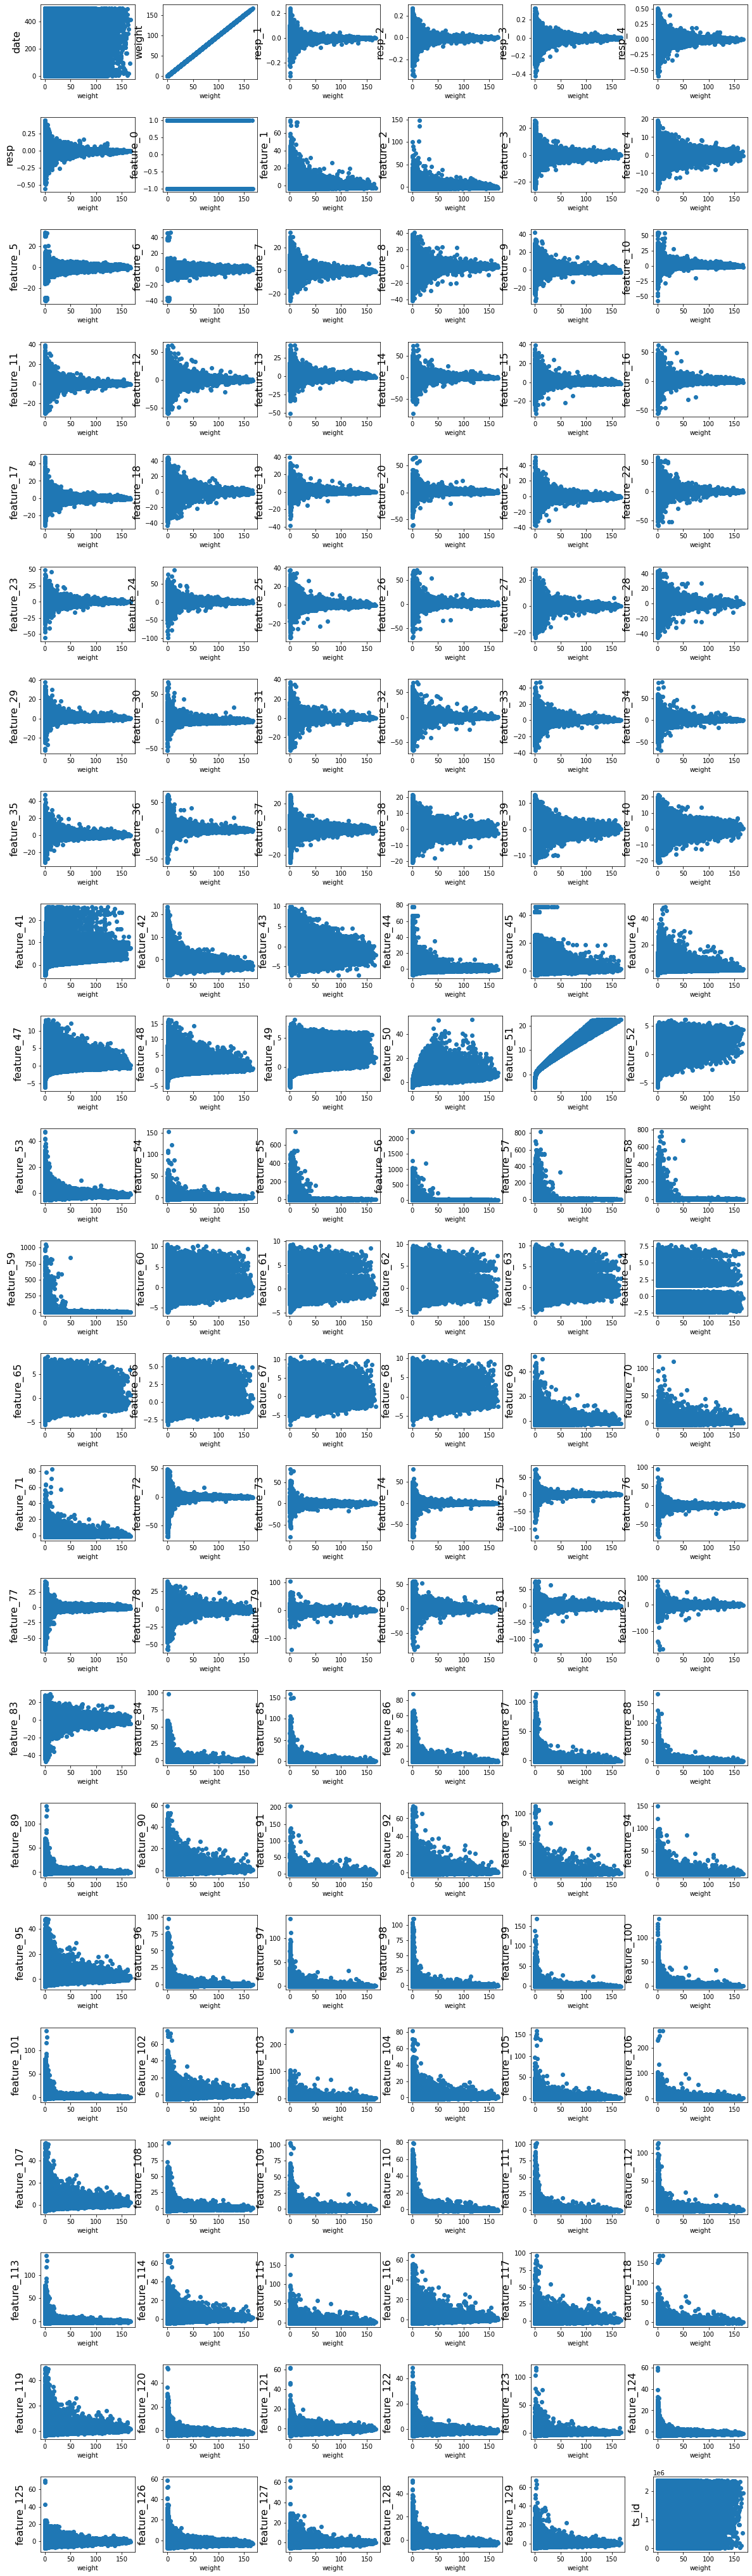

In [34]:
# Weight vs Other Data Plots

fig = plt.figure(figsize=(20,74))
grid =  gridspec.GridSpec(23,6,figure=fig,hspace=.5,wspace=.3)
count = 0
for i in range(23):
    for j in range(6):
        subf = fig.add_subplot(grid[i, j]);
        
        subf.scatter(train_wt_n0['weight'], train_wt_n0.iloc[:, count])
        subf.set_xlabel('weight')        
        subf.set_ylabel(train_wt_n0.columns[count], fontsize=16) 
        count += 1
        



# Observations from scatter plots of weight vs other data:

1. There are some normal distribution shape

2. Some plots are skewed distribution

3. Can clearly see some sparse data on some plots. Those data could be the outliers of features





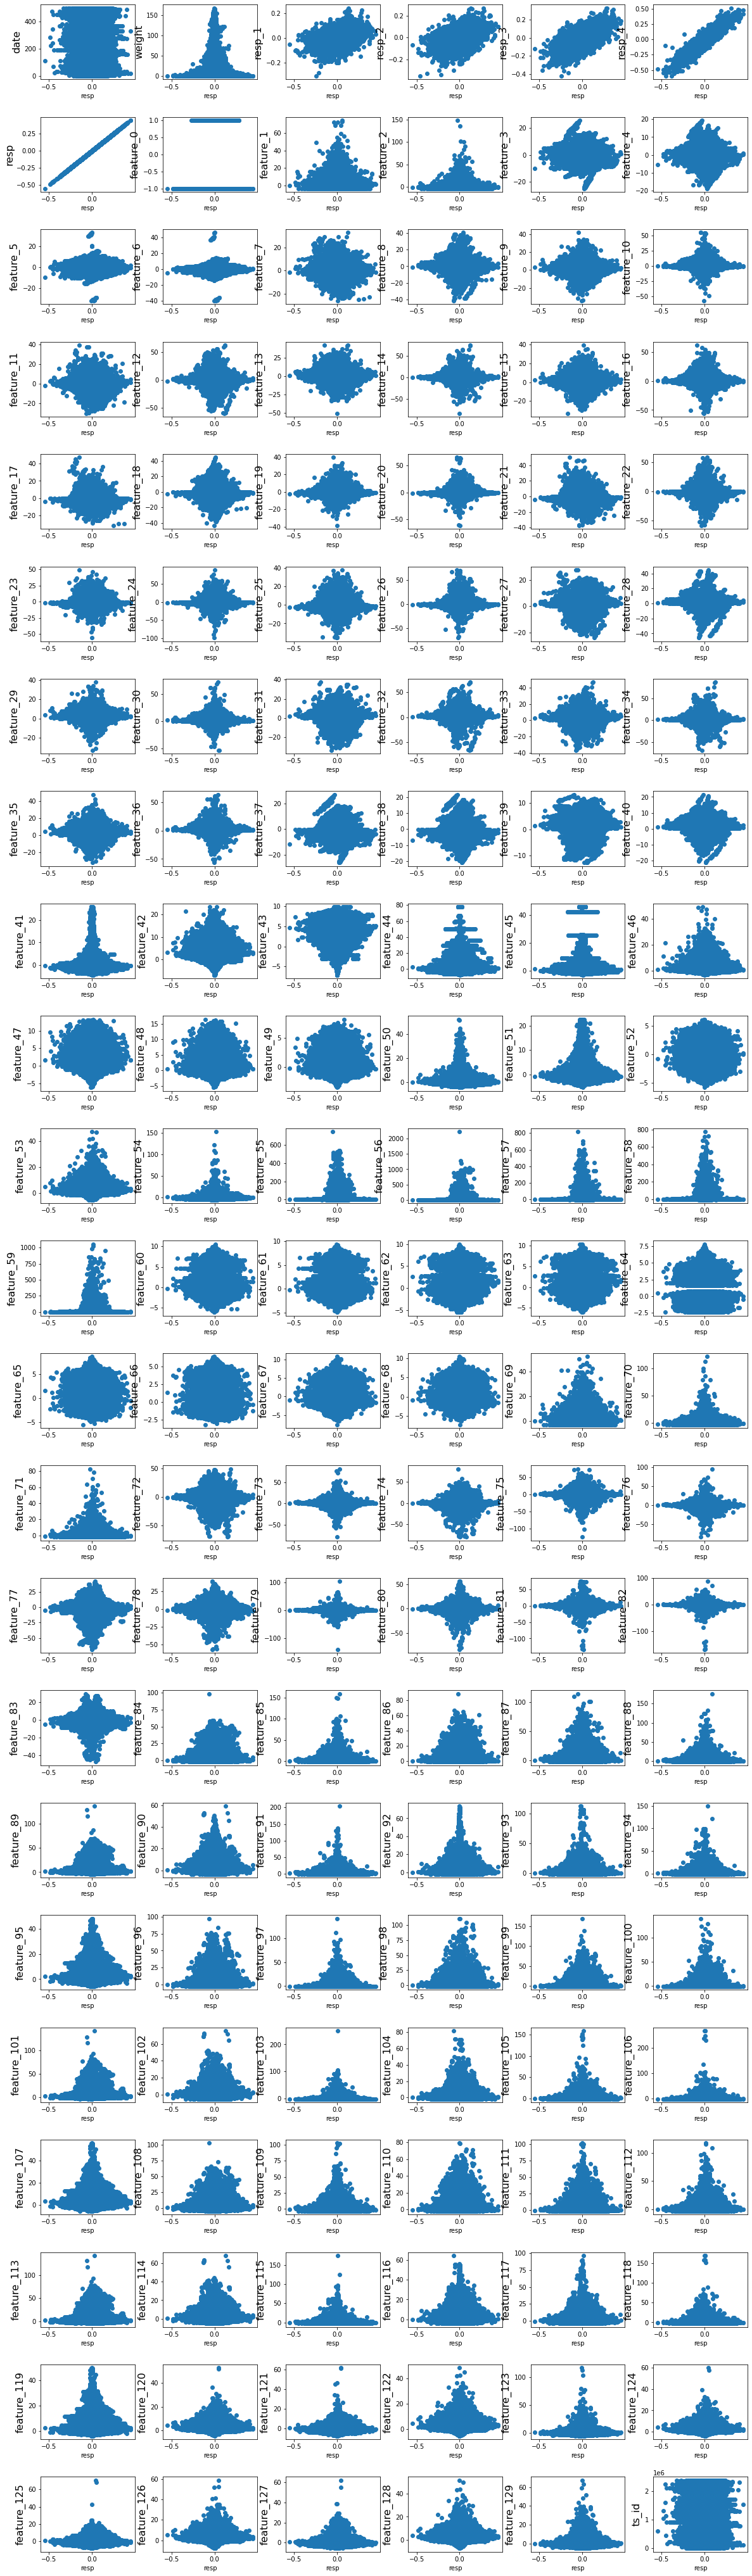

In [16]:
# Resp vs Features Plots

fig = plt.figure(figsize=(20,74))
grid =  gridspec.GridSpec(23,6,figure=fig,hspace=.5,wspace=.3)
count = 0
for i in range(23):
    for j in range(6):
        subf = fig.add_subplot(grid[i, j]);
        
        subf.scatter(train_wt_n0['resp'], train_wt_n0.iloc[:, count])
        subf.set_xlabel('resp')        
        subf.set_ylabel(train_wt_n0.columns[count], fontsize=16) 
        count += 1
        

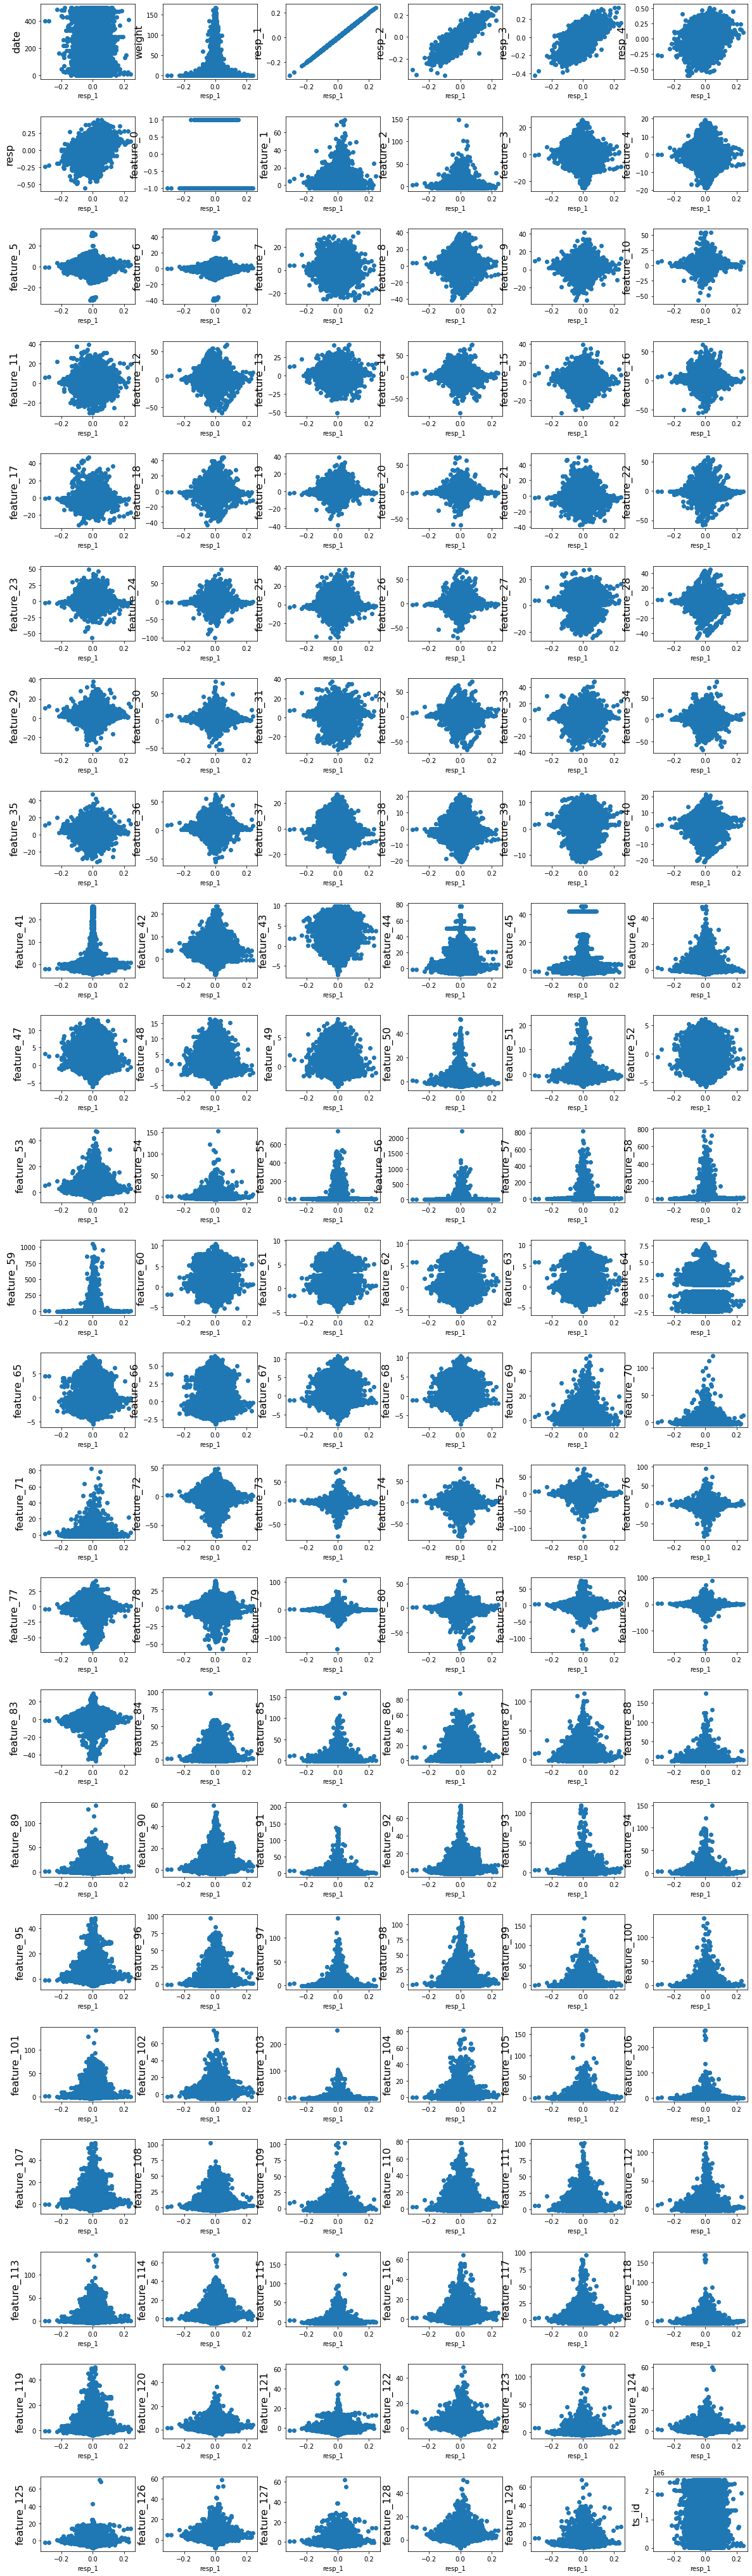

In [17]:
# Resp1 vs Features Plots

fig = plt.figure(figsize=(20,74))
grid =  gridspec.GridSpec(23,6,figure=fig,hspace=.5,wspace=.3)
count = 0
for i in range(23):
    for j in range(6):
        subf = fig.add_subplot(grid[i, j]);
        
        subf.scatter(train_wt_n0['resp_1'], train_wt_n0.iloc[:, count])
        subf.set_xlabel('resp_1')        
        subf.set_ylabel(train_wt_n0.columns[count], fontsize=16) 
        count += 1

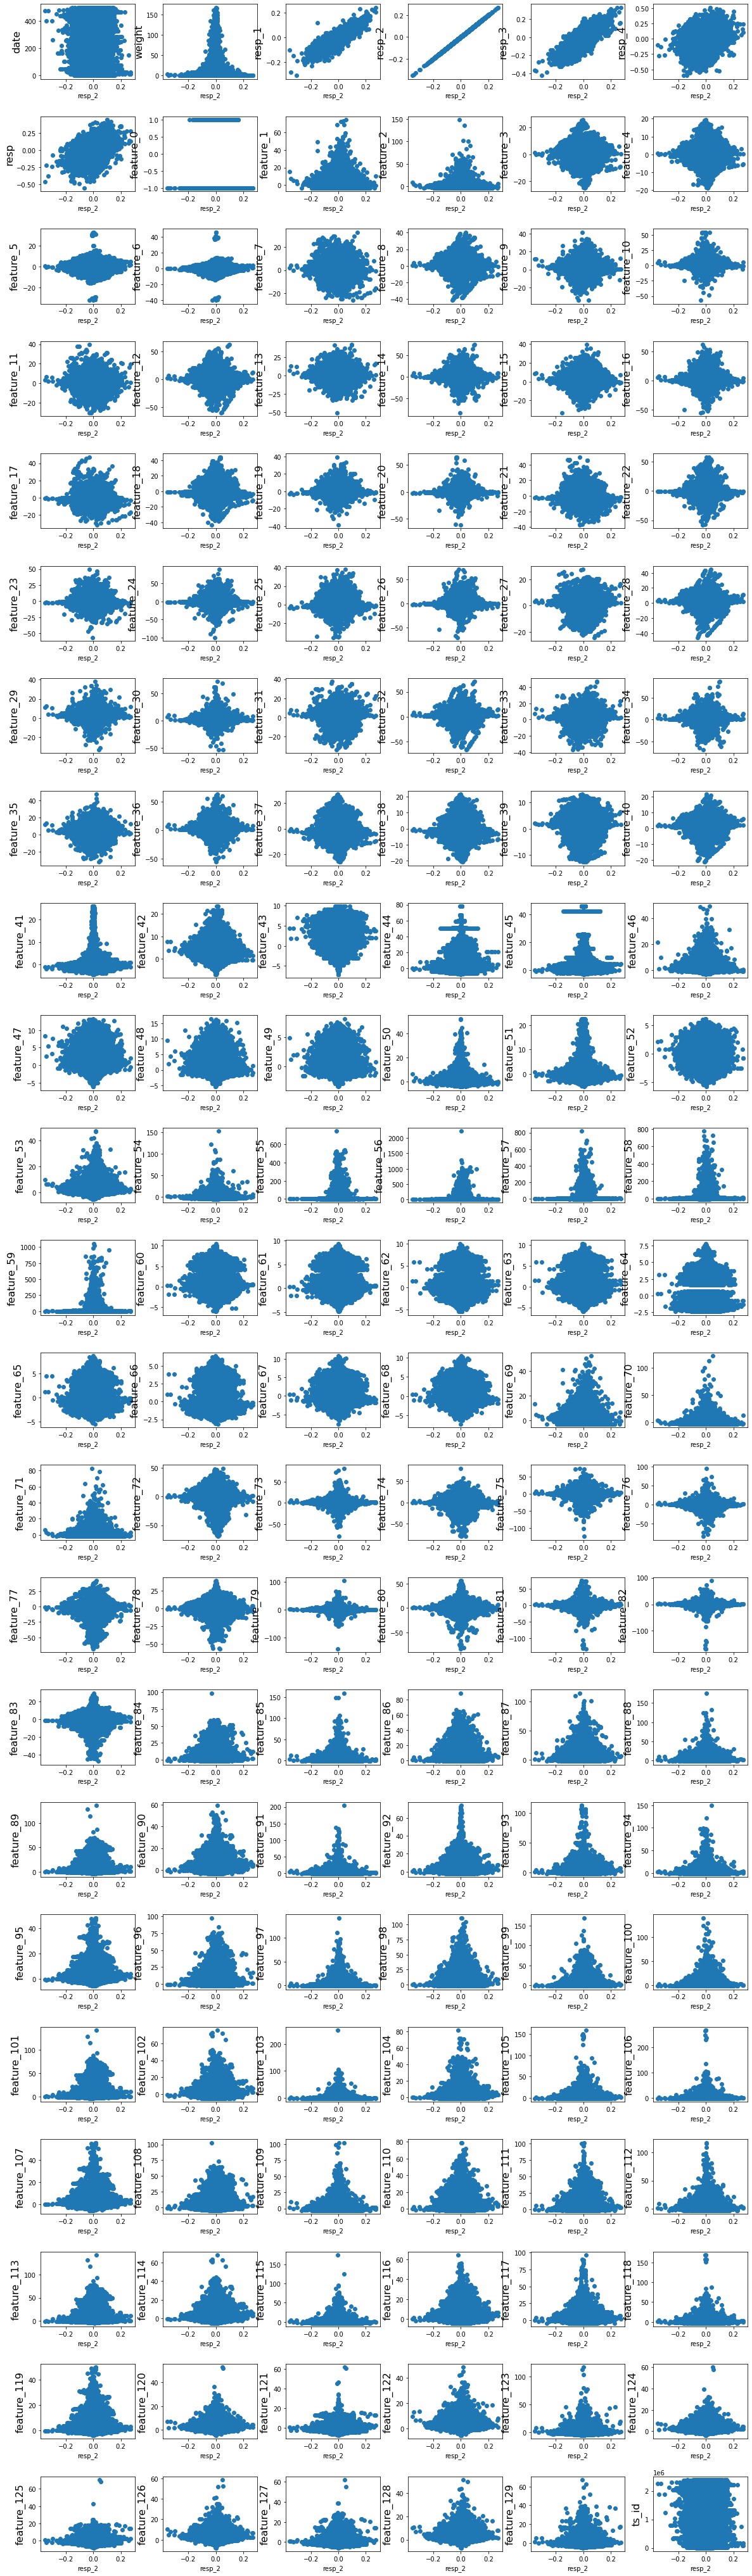

In [19]:
# Resp2 vs Features Plots

fig = plt.figure(figsize=(20,74))
grid =  gridspec.GridSpec(23,6,figure=fig,hspace=.5,wspace=.3)
count = 0
for i in range(23):
    for j in range(6):
        subf = fig.add_subplot(grid[i, j]);
        
        subf.scatter(train_wt_n0['resp_2'], train_wt_n0.iloc[:, count])
        subf.set_xlabel('resp_2')        
        subf.set_ylabel(train_wt_n0.columns[count], fontsize=16) 
        count += 1

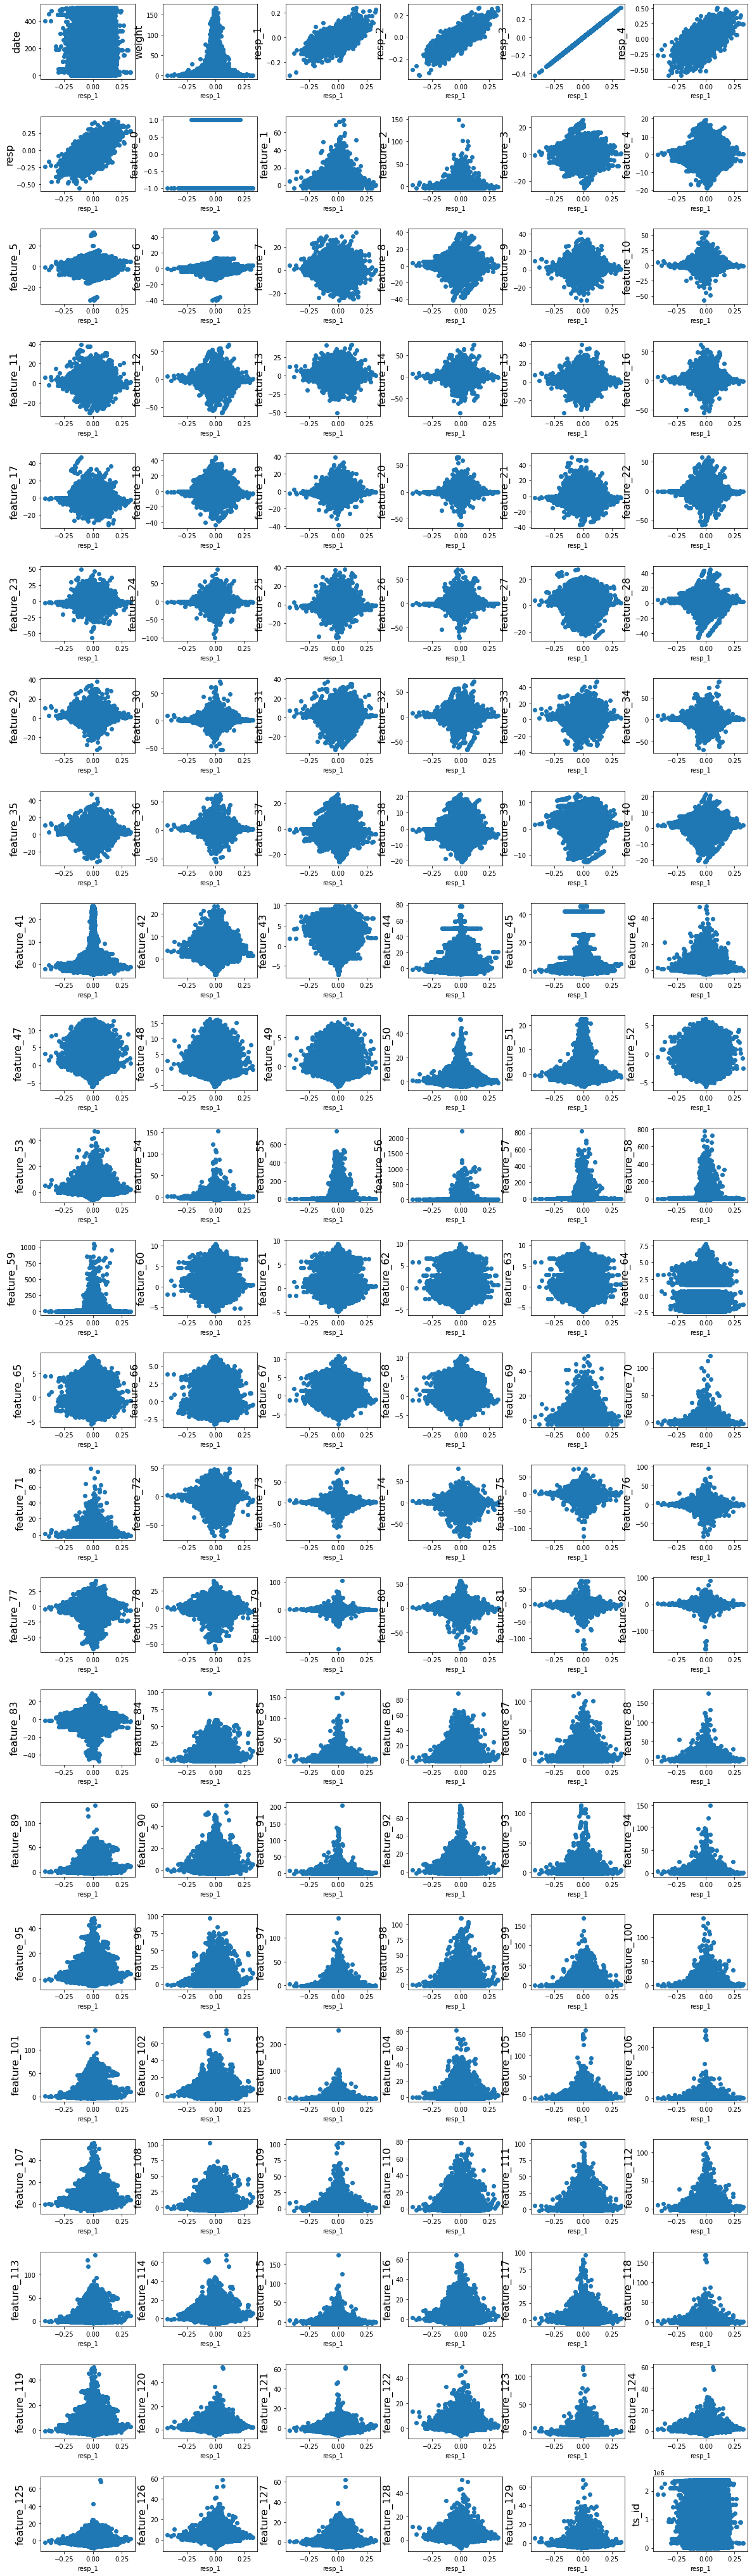

In [20]:
# Resp3 vs Features Plots

fig = plt.figure(figsize=(20,74))
grid =  gridspec.GridSpec(23,6,figure=fig,hspace=.5,wspace=.3)
count = 0
for i in range(23):
    for j in range(6):
        subf = fig.add_subplot(grid[i, j]);
        
        subf.scatter(train_wt_n0['resp_3'], train_wt_n0.iloc[:, count])
        subf.set_xlabel('resp_1')        
        subf.set_ylabel(train_wt_n0.columns[count], fontsize=16) 
        count += 1

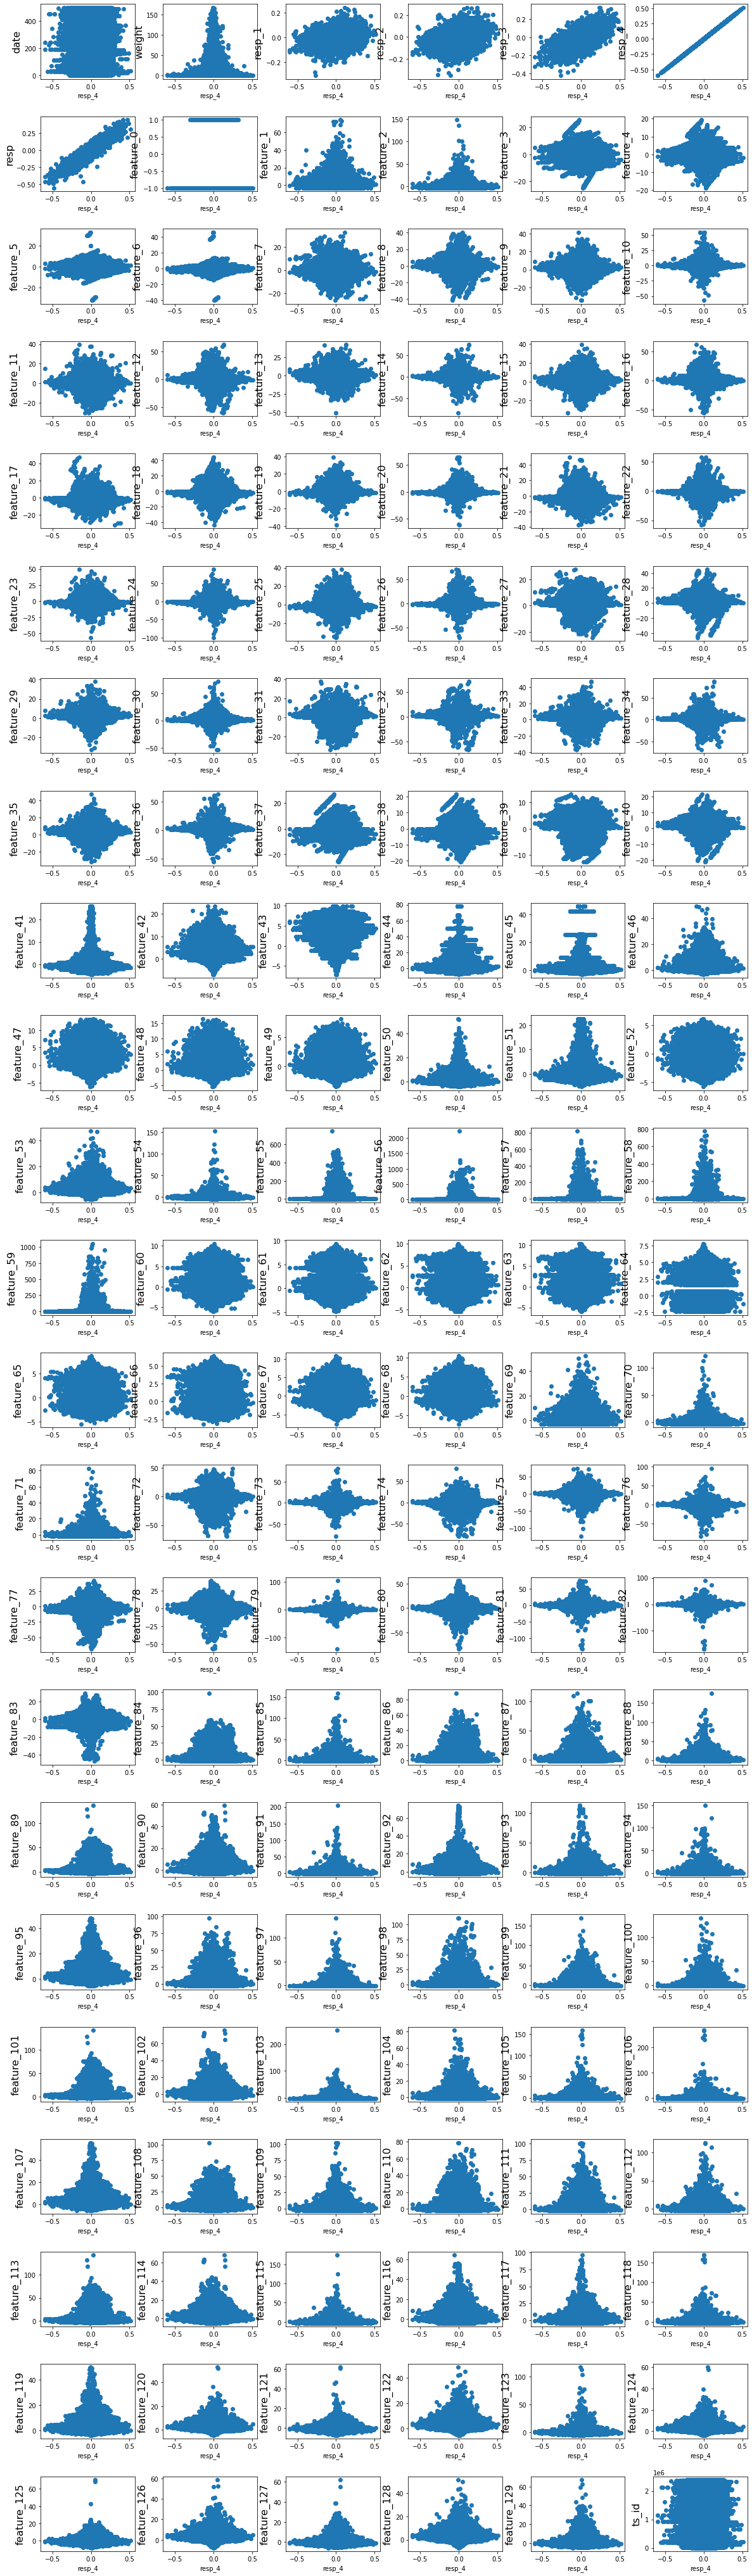

In [36]:
# Resp4 vs Features Plots

fig = plt.figure(figsize=(20,74))
grid =  gridspec.GridSpec(23,6,figure=fig,hspace=.5,wspace=.3)
count = 0
for i in range(23):
    for j in range(6):
        subf = fig.add_subplot(grid[i, j]);
        
        subf.scatter(train_wt_n0['resp_4'], train_wt_n0.iloc[:, count])
        subf.set_xlabel('resp_4')        
        subf.set_ylabel(train_wt_n0.columns[count], fontsize=16) 
        count += 1

# Observations from resps vs other data:

1. There's no obvious phenomena


In [37]:
# Try to find if weight correlates to the features/resps

wt_coef = train_wt_n0[train_wt_n0.columns[1:]].corr()['weight'][:]

In [38]:
type(train_wt_n0[['feature_59', 'weight']].corr()['weight'][:])

pandas.core.series.Series

In [39]:
wt_coef1 = wt_coef[(abs(wt_coef) > 0.1)]  

In [40]:
wt_coef1

weight         1.000000
feature_9     -0.101399
feature_41     0.420397
feature_42    -0.278187
feature_43    -0.219345
feature_46     0.156869
feature_48     0.112385
feature_49     0.252420
feature_50     0.576690
feature_51     0.912904
feature_52     0.337440
feature_53    -0.232621
feature_70     0.269977
feature_115    0.113146
feature_120   -0.275872
feature_122   -0.251589
feature_124   -0.266356
feature_126   -0.275810
feature_128   -0.262942
Name: weight, dtype: float64

### From the definition of correlation, it seems that weight only has strong relationship with feature_51. However, from the scatter plots, there are quite a few features showing normal distribution relationship with weight. For those relationships, it can be expressed as wt = exp(0.5*((feature-mean)/std_dev)**2)/(std_dev*sqrt(2*pi)). If this is true, we should be able to get close value using the formula. 

In [42]:
# Since the return is related to weight and resp. Add a column wt_resp which is weight x resp. 
# Sort the dataframe by wt_resp. Plot the features vs wt_resp to see how they change

In [16]:
train_wt_n0['wt_resp'] = train_wt_n0['weight'] * train_wt_n0['resp']
train_wt_n0.head()

date    weight    resp_1    resp_2    resp_3    resp_4      resp  \
479     0  1.887768  0.011752  0.014947  0.015753  0.018192  0.020704   
480     0  0.993648  0.006912 -0.000236 -0.008789 -0.021067 -0.019047   
483     0  3.942676 -0.002912 -0.000503  0.001928  0.000034 -0.000294   
489     0  7.008368 -0.001950 -0.002721 -0.005041 -0.003581 -0.002728   
491     0  0.319410  0.013140  0.018152  0.028973  0.018599  0.007430   

     feature_0  feature_1  feature_2  ...  feature_122  feature_123  \
479          1   0.086238  -1.370409  ...     0.528743    -1.237860   
480         -1   2.540471   1.213258  ...     3.047750     0.169149   
483         -1  -2.425002  -2.544622  ...     0.616460     2.895219   
489         -1   1.914958   0.138352  ...    -0.134683    -1.304993   
491          1   2.118150   0.202468  ...     3.602020     0.637190   

     feature_124  feature_125  feature_126  feature_127  feature_128  \
479     1.610215     0.931161     2.236798     0.563850     1.023031   
480     3.513960     1.320900     3.726736     0.085196     3.322019   
483     0.441397     3.658603     0.552315     2.694183     0.781045   
489     0.929085     1.227290     1.183403     0.628978     0.621575   
491     2.598988     0.100889     3.195379    -0.344094     2.785174   

     feature_129  ts_id   wt_resp  
479    -0.635663    479  0.039084  
480     0.044636    480 -0.018926  
483     2.948364    483 -0.001158  
489    -0.071838    489 -0.019120  
491    -0.366129    491  0.002373  

[5 rows x 139 columns]

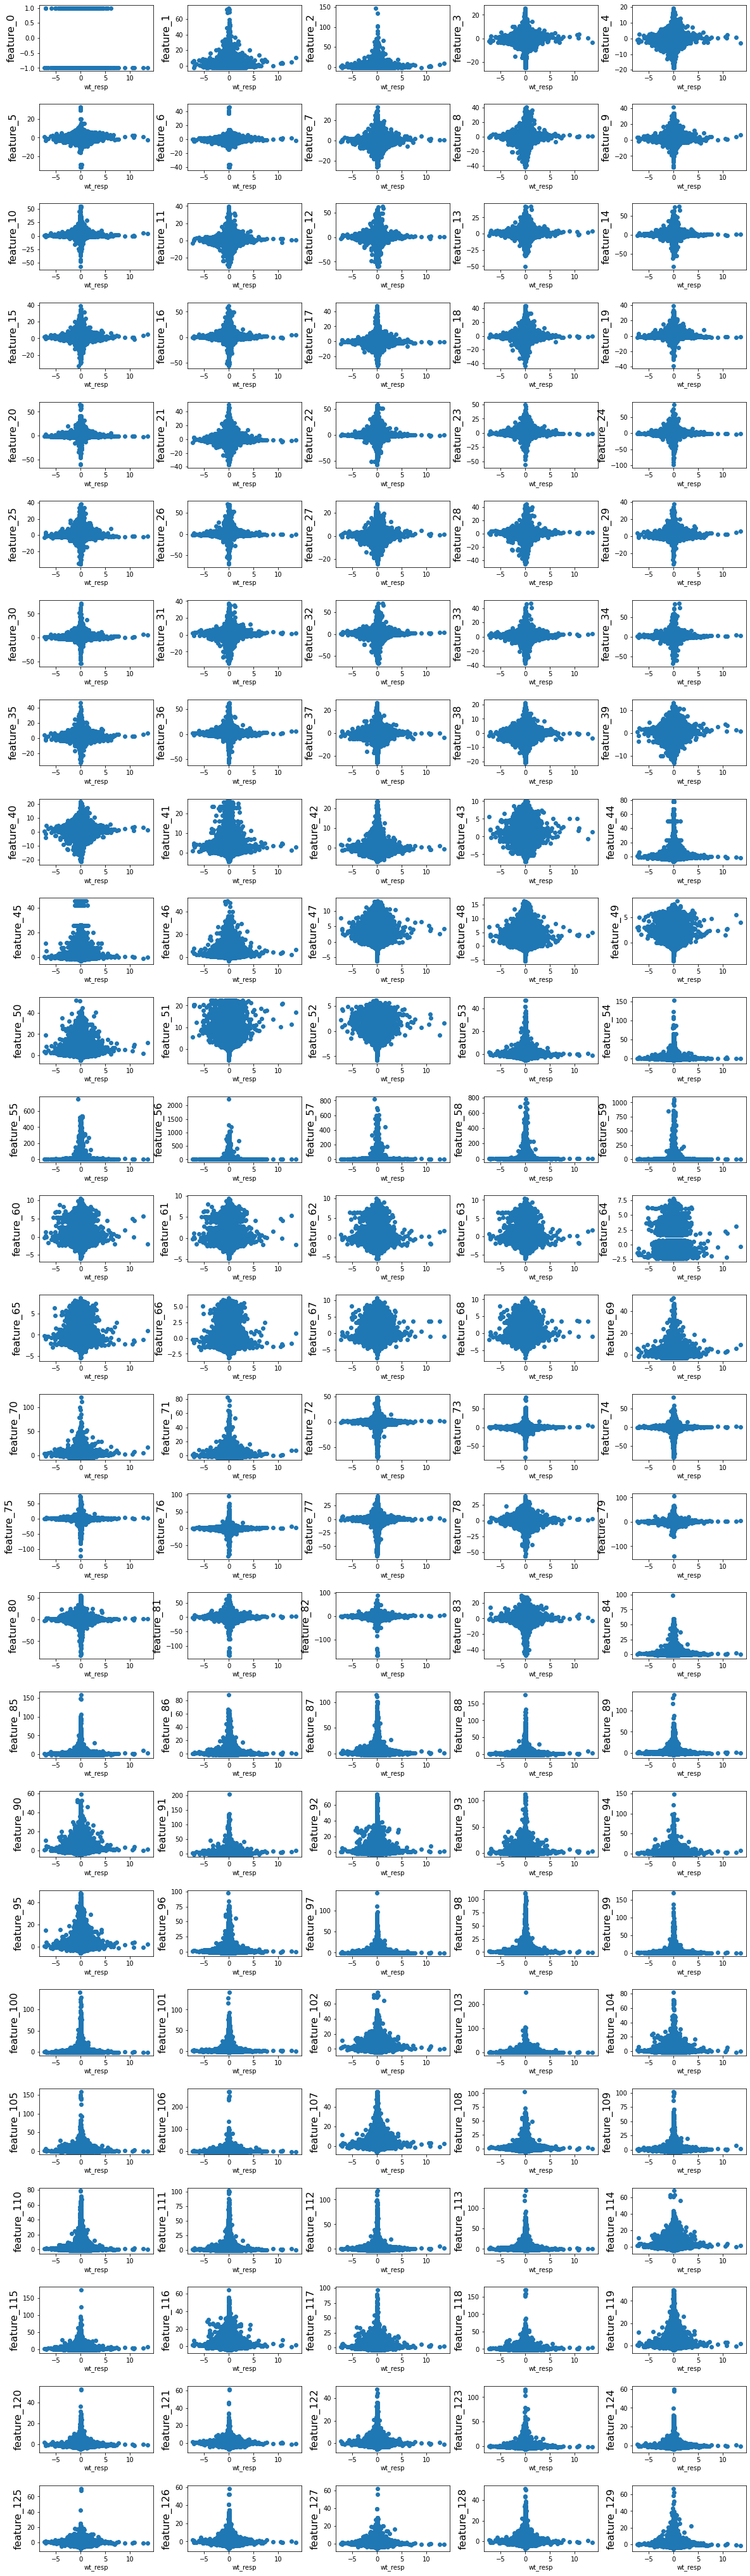

In [18]:
# Wt_resp vs Features

fig = plt.figure(figsize=(20,74))
grid =  gridspec.GridSpec(26,5,figure=fig,hspace=.5,wspace=.3)
count = 0 
for i in range(26):
    for j in range(5):
        subf = fig.add_subplot(grid[i, j]);
        
        subf.scatter(train_wt_n0['wt_resp'], train_wt_n0.iloc[:, count+7])
        subf.set_xlabel('wt_resp')        
        subf.set_ylabel(train_wt_n0.columns[count+7], fontsize=16) 
        count += 1

# Observation from weight*resp vs other data

1. No obvious relationship

